In [7]:
import sys
sys.path.append("../")
from src import Estrategia, agrega_estrategias
import sqlite3
import pandas as pd

#Cargar base de días hábiles
dbpath = r'../data_auxiliar/db_habiles.db'
conn_habiles = sqlite3.connect(dbpath)
df_dias_habiles = pd.read_sql('SELECT * FROM HABILES',
                         conn_habiles, parse_dates=['Fecha'])

# PARAMETROS PARA DEFINIR LA ESTRATEGIA
#fecha_ini = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d').date()
fecha_ini = pd.to_datetime('2014-01-01')
fecha_end = pd.to_datetime('2020-11-23')

afp = 'HABITAT'
monto_inicial = 100
lag_solicitud = 0

In [9]:
estrategia_a = Estrategia(fecha_ini, fecha_end, 'A')
estrategia_e = Estrategia(fecha_ini, fecha_end, 'E')
estrategia_ff = Estrategia(fecha_ini, fecha_end, 'FF',
                           '../2_avisos_cambio_fondos/anuncios_ff.xlsx')

lista_estrategias = [estrategia_a, estrategia_e, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, lag_solicitud)
df.head(5)

,Fecha,Val_A_lag_0,Val_E_lag_0,Val_FF_lag_0
0,2014-01-01,100.000000,100.000000,100.000000
1,2014-01-02,100.336932,100.033161,100.336932
2,2014-01-03,100.253135,100.009698,100.253135
3,2014-01-04,100.253135,100.009698,100.253135
4,2014-01-05,100.253135,100.009698,100.253135


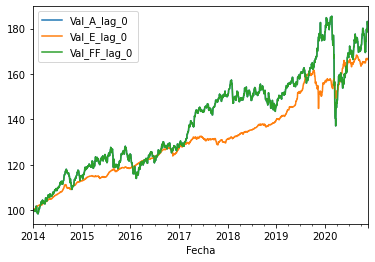

In [10]:
df.set_index('Fecha').plot()

### 2. Comparemos la estrategia FF versus fondo A y fondo E, con LAG = 2

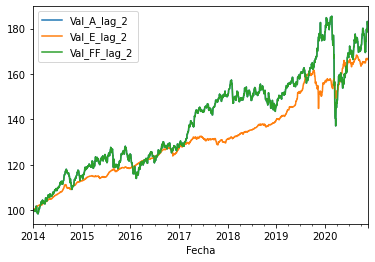

In [13]:
df = agrega_estrategias(lista_estrategias, df_dias_habiles, 
                        afp, monto_inicial, lag_solicitud=2)
df.set_index('Fecha').plot()

### 3. Comparemos fondo A versus estrategia FF con 0 y 2 dias de LAG 

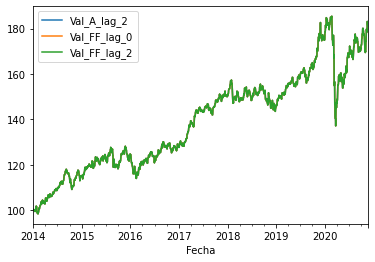

In [16]:
lista_estrategias = [estrategia_a, estrategia_ff, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, [2, 0, 2])
df.set_index('Fecha').plot()

### 4. Comparemos fondo A versus estrategia FF verus estrategia "MAX"

**HIPOTESIS:** Si alguien tiene la capacidad para "predecir" al mercado, su curva de rendimientos debería estar entre la curva pasiva y la curva de mejores rendimientos (Estrategia "MAX").

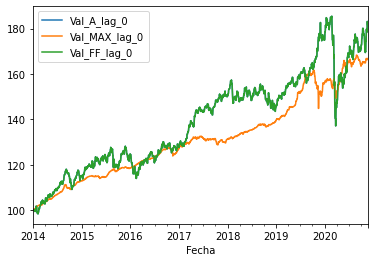

In [19]:
estrategia_max = Estrategia(fecha_ini, fecha_end, 'MAX',
                            '../2_avisos_cambio_fondos/optima_HABITAT.xlsx')

lista_estrategias = [estrategia_a, estrategia_max, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles, afp, monto_inicial, 0)
df.set_index('Fecha').plot()